# VAE

In [ ]:
!pip install k-diffusion

In [2]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [3]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.training import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

Generating test split: 100%|██████████| 10000/10000 [00:01<00:00, 5694.88 examples/s]


In [6]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o).flatten() for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [7]:
dl = dls.valid
xb, yb = b = next(iter(dl))

In [8]:
## Autoencoder

In [9]:
ni, nh, nl = 784, 400, 200

In [10]:
def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act: layers.append(act())
    if norm: layers.append(norm(nf))
    return layers

In [11]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
        init.kaiming_normal_(m.weight, a=leaky)

In [12]:
iw = partial(init_weights, leaky=0.1)
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh), lin(nh, nl))
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)
    
    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

In [13]:
opt_func = partial(optim.Adam, eps=1e-5)

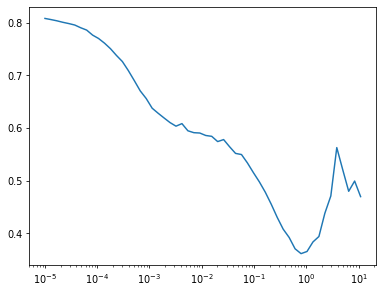

In [14]:
Learner(Autoenc(), dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [15]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = Autoenc()
learn = Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.528,0,train
0.464,0,eval
0.400,1,train
0.352,1,eval
0.316,2,train
0.299,2,eval
0.286,3,train
0.284,3,eval
0.276,4,train
0.276,4,eval


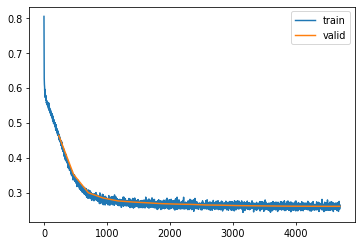

In [21]:
# learn.fit(epochs)

In [24]:
# torch.save(model, '../models/vae_20.pkl')
learn.model = model = torch.load('../models/vae_20.pkl', map_location=torch.device(def_device))

In [25]:
with torch.no_grad(): t = to_cpu(model(xb.to(def_device)).float())

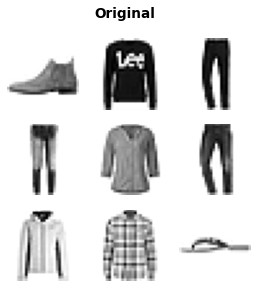

In [26]:
show_images(xb[:9].reshape(-1,1,28,28), imsize=1.5, title='Original');

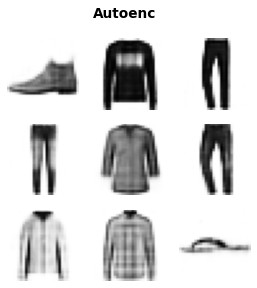

In [27]:
show_images(t[:9].reshape(-1,1,28,28).sigmoid(), imsize=1.5, title='Autoenc');

In [28]:
noise = torch.randn(16, nl).cuda()
with torch.no_grad(): generated_images = model.dec(noise).sigmoid()

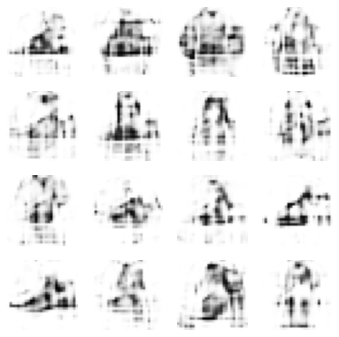

In [29]:
show_images(generated_images.reshape(-1, 1, 28, 28), imsize=1.5)

## VAE

sd vae is 3 down, 1 no-down, mid, conv, sampling, conv, mid, 3 up, 1 no-up

In [16]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh))
        self.mu, self.lf = lin(nh, nl, act=None), lin(nh, nl, act=None)
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)

    def forward(self, x):
        x = self.enc(x)
        mu, lv = self.mu(x), self.lf(x)
        z = mu + (0.5 * lv).exp() * torch.randn_like(lv)
        return self.dec(z), mu, lv


In [17]:
def kld_loss(inp, x):
    x_hat, mu, lv = inp
    return -0.5 * (1 + lv - mu.pow(2) - lv.exp()).mean()

def bce_loss(inp, x): return F.binary_cross_entropy_with_logits(inp[0], x)

def vae_loss(inp, x): return kld_loss(inp, x) + bce_loss(inp, x)

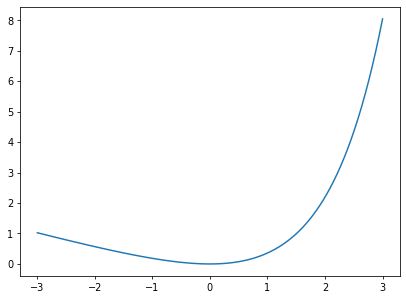

In [18]:
x = torch.linspace(-3, 3, 100)
plt.figure(figsize=(7, 5))
plt.plot(x, -0.5 * (1 + x - x.exp()));

low variance latents would result in v peaked distribution around the mean -> less diversity, limited ability to reconstruct data accurately, harder to generate data different from training data

high variance would result in high diversity, more noisy data, reduced correlation between latent codes and the data, easier to generate new data but more unrealistic or desired/useful

In [19]:
class FuncMetric(Mean):
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets):
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [20]:
metrics = MetricsCB(kld=FuncMetric(kld_loss), bce=FuncMetric(bce_loss))
opt_func = partial(optim.Adam, eps=1e-5)

In [21]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, BatchSchedCB(sched), MixedPrecision()]
model = VAE()
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=opt_func)

kld,bce,loss,epoch,train
0.426,0.546,0.973,0,train
0.262,0.489,0.751,0,eval
0.099,0.445,0.544,1,train
0.046,0.407,0.453,1,eval
0.034,0.382,0.416,2,train
0.036,0.364,0.400,2,eval
0.035,0.356,0.391,3,train
0.037,0.351,0.388,3,eval
0.036,0.347,0.382,4,train
0.037,0.341,0.378,4,eval


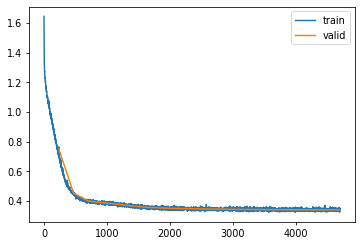

In [22]:
learn.fit(epochs)

In [24]:
torch.save(model, '../models/vae_variational_20.pkl')

## VAE Sample

In [25]:
with torch.no_grad(): t, mu, lv = to_cpu(model(xb.to(def_device)))

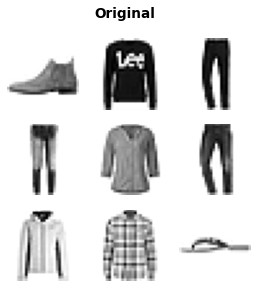

In [26]:
show_images(xb[:9].reshape(-1,1,28,28), imsize=1.5, title='Original');

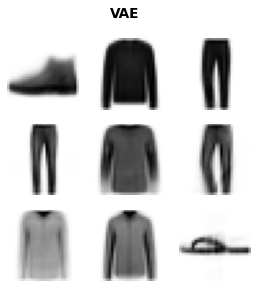

In [27]:
show_images(t[:9].reshape(-1,1,28,28).sigmoid(), imsize=1.5, title='VAE');

In [29]:
noise = torch.randn(16, nl).to(def_device)
with torch.no_grad(): ims = to_cpu(model.dec(noise).sigmoid())

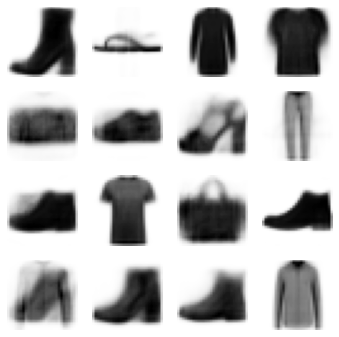

In [30]:
show_images(ims.reshape(-1, 1, 28, 28), imsize=1.5)